In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fpt-ck/Simplize_FPT_PriceHistory_20250315.xlsx
/kaggle/input/fpt-ck/Simplize_FPT_FinancialIndicator_20250315.xlsx


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 120)

FINANCIAL_PATH = "/kaggle/input/fpt-ck/Simplize_FPT_FinancialIndicator_20250315.xlsx"
PRICE_PATH     = "/kaggle/input/fpt-ck/Simplize_FPT_PriceHistory_20250315.xlsx"
SKIPROWS_SIMPLIZE = 5
WINDOW_DAYS = 14


In [8]:
import re

def parse_vn_number(x):
    """
    Trả về float từ chuỗi số theo nhiều tình huống:
    - Nếu đồng thời có cả '.' và ',' -> mặc định '.' là dấu nghìn, ',' là thập phân
    - Nếu có >1 dấu '.' mà không có ',' -> coi '.' là nghìn
    - Nếu có >1 dấu ',' mà không có '.' -> coi ',' là nghìn
    - Nếu chỉ có 1 trong 2:
        + Nếu chỉ có ',' -> coi ',' là thập phân
        + Nếu chỉ có '.' -> coi '.' là thập phân (không xóa)
    - Giữ lại dấu âm (cả dạng (123) -> -123)
    - Bỏ ký tự không phải số, dấu . , - 
    - Nếu đầu vào đã là số (int/float) -> trả nguyên (không đụng chạm)
    """
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return np.nan
    if isinstance(x, (int, float)):
        return float(x)

    s = str(x).strip()
    if s == "" or s.lower() in {"nan", "none", "null"}:
        return np.nan

    # âm dạng (123)
    neg = False
    if s.startswith('(') and s.endswith(')'):
        neg = True
        s = s[1:-1]

    # bỏ đơn vị/ký tự lạ nhưng giữ . , và -
    s = re.sub(r"[^0-9\-,\.]", "", s)

    if '.' in s and ',' in s:
        # ví dụ '12.345,67' -> '12345.67'
        s = s.replace('.', '').replace(',', '.')
    else:
        if s.count('.') > 1 and ',' not in s:
            # '1.234.567' -> '1234567'
            s = s.replace('.', '')
        elif s.count(',') > 1 and '.' not in s:
            # '1,234,567' -> '1234567'
            s = s.replace(',', '')
        else:
            # chỉ còn 1 dấu, quyết định vai trò:
            if ',' in s and '.' not in s:
                # ',' là thập phân
                s = s.replace(',', '.')
            # nếu chỉ có '.' thì coi '.' là thập phân -> giữ nguyên

    try:
        val = float(s)
    except:
        return np.nan

    return -val if neg else val


In [9]:
# Đọc mọi cột dạng chuỗi để tự làm sạch
price_raw = pd.read_excel(PRICE_PATH, sheet_name="Sheet 1", skiprows=SKIPROWS_SIMPLIZE, dtype=str)

def norm_col(s):
    return str(s).strip().upper().replace('\n',' ').replace('  ',' ')

price_raw.columns = [norm_col(c) for c in price_raw.columns]

price_colmap_guess = {
    'NGÀY': 'date',
    'GIÁ ĐÓNG CỬA': 'close',
    'GIÁ MỞ CỬA': 'open',
    'GIÁ CAO NHẤT': 'high',
    'GIÁ THẤP NHẤT': 'low',
    'THAY ĐỔI GIÁ': 'chg',
    '% THAY ĐỔI': 'pct_chg',
    'KHỐI LƯỢNG': 'volume'
}
price_colmap = {k:v for k,v in price_colmap_guess.items() if k in price_raw.columns}
price = price_raw.rename(columns=price_colmap).copy()

# Ép kiểu ngày
price['date'] = pd.to_datetime(price['date'], dayfirst=True, errors='coerce')

# Làm sạch số bằng parse_vn_number, chỉ trên cột tồn tại
for c in ['open','high','low','close','chg','volume']:
    if c in price.columns:
        price[c] = price[c].map(parse_vn_number)

# % thay đổi -> tỷ lệ
if 'pct_chg' in price.columns:
    price['pct_chg'] = price['pct_chg'].astype(str).str.replace('%','', regex=False)
    price['pct_chg'] = price['pct_chg'].map(parse_vn_number) / 100.0

# Sắp xếp & lọc ngày hợp lệ
price = price.dropna(subset=['date']).sort_values('date').reset_index(drop=True)

print("PRICE columns:", price.columns.tolist())
price.head(10)


PRICE columns: ['date', 'open', 'high', 'low', 'close', 'chg', 'pct_chg', 'volume']


/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,date,open,high,low,close,chg,pct_chg,volume
0,2021-03-15,38801.345107,39257.235584,38548.072619,38750.690609,NaN,NaN,1801400.0
1,2021-03-16,39003.963097,41283.415486,38801.345107,41030.142998,NaN,NaN,5171000.0
2,2021-03-17,41283.415486,41283.415486,40523.598023,40928.834003,NaN,NaN,2573500.0
3,2021-03-18,41030.142998,41030.142998,40523.598023,41030.142998,NaN,NaN,2177500.0
4,2021-03-19,40523.598023,40776.870510,40219.671037,40422.289028,NaN,NaN,2923500.0
5,2021-03-22,40270.325535,40320.980033,39662.471565,39865.089555,NaN,NaN,3074800.0
6,2021-03-23,39763.780560,40523.598023,39662.471565,39915.744052,NaN,NaN,2333200.0
7,2021-03-24,39459.853575,39966.398550,38750.690609,39003.963097,NaN,NaN,2788500.0
8,2021-03-25,39257.235584,39257.235584,38750.690609,38801.345107,NaN,NaN,2355400.0
9,2021-03-26,38598.727117,38902.654102,37737.600659,38548.072619,NaN,NaN,2672600.0


In [12]:
financial_raw = pd.read_excel(FINANCIAL_PATH, sheet_name="Sheet 1", skiprows=SKIPROWS_SIMPLIZE + 1, dtype=str)
financial_raw.columns = [norm_col(c) for c in financial_raw.columns]
financial_raw.head()


/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,CHỈ TIÊU,Q4/2024,Q3/2024,Q2/2024,Q1/2024,Q4/2023,Q3/2023,Q2/2023,Q1/2023,Q4/2022,Q3/2022,Q2/2022,Q1/2022,Q4/2021,Q3/2021,Q2/2021,Q1/2021,Q4/2020,Q3/2020,Q2/2020,Q1/2020,Q4/2019,Q3/2019,Q2/2019,Q1/2019,Q4/2018,Q3/2018,Q2/2018,Q1/2018,Q4/2017,Q3/2017,Q2/2017,Q1/2017,Q4/2016,Q3/2016,Q2/2016,Q1/2016,Q4/2015,Q3/2015,Q2/2015,Q1/2015
0,Chỉ tiêu Báo cáo kết quả kinh doanh (Tỷ đồng),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Doanh thu thuần,17607817805892,15902821715757,15245226416020,14092928413699,14690412703323,13761744975857,12484364264902,11681378883303,13042426271109,11148559020353,10096060090959,9730253844391,10704055633280,8725171956972,8641707284821,7586327669954,8666704612977,7553128504072,6980002498337,6630564911438,8120187874196,7104374137543,6825918524598,5666479616064,6952446588573,6036058933435,5474262724100,4750768611617,12495737352665,10831198037445,9946702598780,9418119567621,12399573089770,9755288350096,8958526432579,8466518261019,10449042783674,9527463506576,9328539915897,8641481450290
2,Tăng trưởng doanh thu,0.1986,0.15560000000000002,0.2211,0.2064,0.1264,0.23440000000000003,0.2366,0.2005,0.21850000000000003,0.2777,0.16829999999999998,0.2826,0.2351,0.1552,0.23809999999999998,0.1441,0.0673,0.0632,0.0226,0.17010000000000003,0.168,0.177,0.2469,0.1928,-0.4436,-0.44270000000000004,-0.4496,-0.49560000000000004,0.0078000000000000005,0.1103,0.1103,0.1124,0.1867,0.0239,-0.0397,-0.0202,-0.3185,-0.29309999999999997,-0.127,-0.2048
3,Lợi nhuận gộp,6478973351926,6158955664406,5651357322898,5510465680087,5631863560161,5496368967016,4633824307037,4567879000694,5241273784162,4359485692257,3842688349310,3953321292553,4094368175339,3250928734025,3440181142905,2894526954668,3470920950243,2998778191778,2721754673951,2624378378526,3071028277517,2782725269232,2578129542120,2279330299668,2571210747456,2295670242789,2000672597403,1855560326804,2850422016373,2415836625376,2431579550839,2075513389017,2787127572335,2216581048829,1933550359469,1686151346915,2158680586355,1914596624885,1801912782980,1689717875940
4,Tăng trưởng lợi nhuận gộp,0.15039999999999998,0.12050000000000001,0.21960000000000002,0.2064,0.0745,0.2608,0.2059,0.1555,0.2801,0.341,0.11699999999999999,0.36579999999999996,0.1796,0.08410000000000001,0.264,0.10289999999999999,0.13019999999999998,0.0776,0.0557,0.1514,0.19440000000000002,0.2122,0.28859999999999997,0.2284,-0.098,-0.049699999999999994,-0.1772,-0.106,0.0227,0.08990000000000001,0.2576,0.2309,0.29109999999999997,0.1577,0.0731,-0.0021,0.2208,0.1917,0.1595,0.2562


In [13]:
# In danh sách cột để bạn dò
financial_raw.columns.tolist()


['CHỈ TIÊU',
 'Q4/2024',
 'Q3/2024',
 'Q2/2024',
 'Q1/2024',
 'Q4/2023',
 'Q3/2023',
 'Q2/2023',
 'Q1/2023',
 'Q4/2022',
 'Q3/2022',
 'Q2/2022',
 'Q1/2022',
 'Q4/2021',
 'Q3/2021',
 'Q2/2021',
 'Q1/2021',
 'Q4/2020',
 'Q3/2020',
 'Q2/2020',
 'Q1/2020',
 'Q4/2019',
 'Q3/2019',
 'Q2/2019',
 'Q1/2019',
 'Q4/2018',
 'Q3/2018',
 'Q2/2018',
 'Q1/2018',
 'Q4/2017',
 'Q3/2017',
 'Q2/2017',
 'Q1/2017',
 'Q4/2016',
 'Q3/2016',
 'Q2/2016',
 'Q1/2016',
 'Q4/2015',
 'Q3/2015',
 'Q2/2015',
 'Q1/2015']

In [22]:
import re, unicodedata, numpy as np, pandas as pd

# === 1) Đọc không header & tự tìm dòng tiêu đề có các nhãn quý ===
raw = pd.read_excel(FINANCIAL_PATH, sheet_name="Sheet 1", header=None, dtype=str)

def looks_quarter(x):
    if pd.isna(x): return False
    s = unicodedata.normalize('NFKC', str(x)).strip().upper().replace('QUÝ','Q')
    s = re.sub(r'[\/\-\u2010-\u2015]+', '/', s)  # chuẩn hoá mọi dash/slash
    return bool(re.fullmatch(r'Q[1-4]/20\d{2}', s))

header_idx = None
for i in range(min(15, len(raw))):            # dò trong ~15 dòng đầu
    row = raw.iloc[i, 1:50].tolist()          # bỏ cột 0 vì là "CHỈ TIÊU"
    count_q = sum(looks_quarter(c) for c in row)
    if count_q >= 3:                          # có >=3 cột dạng Qx/20xx -> chính là header
        header_idx = i
        break

if header_idx is None:
    raise ValueError("Không tìm thấy hàng tiêu đề quý (Qx/20xx). Hãy hiển thị vài dòng đầu để kiểm tra.")

# Lấy dòng đó làm header
cols = raw.iloc[header_idx].tolist()
cols[0] = 'METRIC'                            # cột đầu là tên chỉ tiêu
df = raw.iloc[header_idx+1:].copy()
df.columns = cols

# === 2) Chuẩn hoá nhãn quý 'Qx/YYYY' -> 'Qx-YYYY' và giữ các cột quý ===
def norm_quarter_label(c):
    s = unicodedata.normalize('NFKC', str(c)).strip().upper().replace('QUÝ','Q')
    s = re.sub(r'[\/\-\u2010-\u2015]+', '-', s)          # Q1/2024 -> Q1-2024
    m = re.fullmatch(r'(20\d{2})-Q([1-4])', s)           # 2024-Q1 -> Q1-2024
    if m: s = f"Q{m.group(2)}-{m.group(1)}"
    return s if re.fullmatch(r'Q[1-4]-20\d{2}', s) else np.nan

qmap  = {c: norm_quarter_label(c) for c in df.columns[1:]}
keep_qcols = [c for c in df.columns[1:] if pd.notna(qmap[c])]

# === 3) Wide -> Long -> Pivot thành 1 dòng/quý ===
m = df.melt(id_vars=['METRIC'], value_vars=keep_qcols,
            var_name='quarter_raw', value_name='val')
m['quarter'] = m['quarter_raw'].map(qmap)

def keyize(s):
    s = unicodedata.normalize('NFKD', str(s))
    s = ''.join(ch for ch in s if unicodedata.category(ch) != 'Mn')
    return re.sub(r'[^a-zA-Z0-9]+','', s).lower()

m['metric_key'] = m['METRIC'].map(keyize)
pivot = m.pivot_table(index='quarter', columns='metric_key',
                      values='val', aggfunc='first').reset_index()

# === 4) Chọn các chỉ tiêu chính nếu có (không có thì bỏ qua) ===
cands = {
    'gross_margin':  ['bienloinhuangop','grossmargin'],
    'net_margin':    ['bienloinhuanrong','netmargin'],
    'pe':            ['pe','priceearnings'],
    'eps':           ['eps','earningpershare','loinhuantrenmoicophieu'],
    'eps_growth':    ['epsgrowth','tangtruongeps'],
    'roe':           ['roe','returnonequity','tisuatsinhlaitrenvonchusohuu'],
    'debt_to_equity':['debttoequity','novoncsh','debtequity'],
    'liquidity':     ['currentratio','khanangthanhtoantongquat','tysothanhtoanhienhanh'],
    'asset_turnover':['assetturnover','vongquaytaisan'],
    'book_value':    ['bookvalue','giatrisosach','bookvaluepershare'],
}
avail = set(pivot.columns.astype(str))
def pick(ts):
    for t in ts:
        hit = [c for c in avail if t in c]
        if hit: return hit[0]
    return None
sel = {k: pick(v) for k,v in cands.items()}

cols = ['quarter'] + [v for v in sel.values() if v]
fin_small = pivot[cols].rename(columns={v:k for k,v in sel.items() if v}).copy()

# ép số VN -> float
def parse_vn_number(x):
    if x is None or (isinstance(x,float) and np.isnan(x)): return np.nan
    if isinstance(x,(int,float)): return float(x)
    s = unicodedata.normalize('NFKC', str(x)).strip().replace('%','')
    if '.' in s and ',' in s: s = s.replace('.','').replace(',', '.')
    else:
        if s.count('.')>1 and ',' not in s: s = s.replace('.','')
        elif s.count(',')>1 and '.' not in s: s = s.replace(',','')
        elif ',' in s and '.' not in s: s = s.replace(',', '.')
    try: return float(s)
    except: return np.nan

for c in fin_small.columns:
    if c != 'quarter':
        fin_small[c] = fin_small[c].map(parse_vn_number)

fin_small = fin_small.drop_duplicates(subset=['quarter']).sort_values('quarter').reset_index(drop=True)
fin_small.head(10)


/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


metric_key,quarter,gross_margin,net_margin,pe,eps_growth,eps_growth,roe,liquidity,asset_turnover,book_value
0,Q1-2015,0.1955,0.0633,10.219301,0.0164,0.0164,0.2685,1.796234,0.385215,21086.616597
1,Q1-2016,0.1992,0.0527,9.809166,-0.2957,-0.2957,0.2457,1.757385,0.334126,19451.369766
2,Q1-2017,0.2204,0.0574,10.453055,0.0335,0.0335,0.2360,1.747684,0.325232,18744.254916
3,Q1-2018,0.3906,0.1374,10.919132,0.0667,0.0667,0.2809,2.250988,0.189893,19469.625089
4,Q1-2019,0.4022,0.1401,10.371886,0.1130,0.1130,0.2290,2.175339,0.193811,19297.368488
5,Q1-2020,0.3958,0.1413,11.790089,0.0321,0.0321,0.2445,2.050322,0.194801,18803.607819
6,Q1-2021,0.3815,0.1517,16.531037,0.0477,0.0477,0.2482,1.797378,0.175968,18334.379041
7,Q1-2022,0.4063,0.1581,19.313467,0.1310,0.1310,0.2686,1.703372,0.178050,17487.068514
8,Q1-2023,0.3910,0.1549,16.678064,0.0414,0.0414,0.2698,2.142787,0.228160,17786.732477
9,Q1-2024,0.3910,0.1533,20.588714,0.0469,0.0469,0.2770,2.047182,0.230371,18374.065310


In [24]:
# Giữ cột quarter + các chỉ tiêu, bỏ cột thừa/đúp
fin_small = fin_small.loc[:, ~fin_small.columns.duplicated()].copy()
if 'metric_key' in fin_small.columns:
    fin_small = fin_small.drop(columns='metric_key')

# Đảm bảo quarter là dạng 'Qx-YYYY'
fin_small['quarter'] = fin_small['quarter'].astype(str)
fin_small.head()


metric_key,quarter,gross_margin,net_margin,pe,eps_growth,roe,liquidity,asset_turnover,book_value
0,Q1-2015,0.1955,0.0633,10.219301,0.0164,0.2685,1.796234,0.385215,21086.616597
1,Q1-2016,0.1992,0.0527,9.809166,-0.2957,0.2457,1.757385,0.334126,19451.369766
2,Q1-2017,0.2204,0.0574,10.453055,0.0335,0.2360,1.747684,0.325232,18744.254916
3,Q1-2018,0.3906,0.1374,10.919132,0.0667,0.2809,2.250988,0.189893,19469.625089
4,Q1-2019,0.4022,0.1401,10.371886,0.1130,0.2290,2.175339,0.193811,19297.368488


In [25]:
import pandas as pd
import numpy as np

WINDOW_DAYS = 14  # theo đề

def quarter_end_dates(start_date, end_date):
    out = []
    for y in range(start_date.year, end_date.year+1):
        for m, d in [(3,31),(6,30),(9,30),(12,31)]:
            dt = pd.Timestamp(y,m,d)
            if start_date <= dt <= end_date:
                out.append(dt)
    return out

# Lấy khoảng thời gian có dữ liệu, nhưng không sớm hơn 2021 (yêu cầu đề)
dmin, dmax = price['date'].min(), price['date'].max()
start = pd.Timestamp(max(2021, dmin.year), 1, 1)
q_end_list = quarter_end_dates(start, dmax)

rows = []
for qd in q_end_list:
    lo, hi = qd - pd.Timedelta(days=WINDOW_DAYS), qd + pd.Timedelta(days=WINDOW_DAYS)
    win = price[(price['date']>=lo) & (price['date']<=hi)]
    rows.append({'quarter_end': qd, 'close_avg': win['close'].mean() if not win.empty else np.nan})

price_quarter = pd.DataFrame(rows).sort_values('quarter_end').reset_index(drop=True)
price_quarter['quarter'] = 'Q' + (((price_quarter['quarter_end'].dt.month-1)//3)+1).astype(str) + '-' + price_quarter['quarter_end'].dt.year.astype(str)
price_quarter['price_change'] = price_quarter['close_avg'].diff()
price_quarter['pct_change']   = price_quarter['close_avg'].pct_change()

price_quarter.head()


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,quarter_end,close_avg,quarter,price_change,pct_change
0,2021-03-31,40156.955945,Q1-2021,NaN,NaN
1,2021-06-30,51186.021001,Q2-2021,11029.065056,0.274649
2,2021-09-30,56491.780683,Q3-2021,5305.759682,0.103656
3,2021-12-31,55527.497568,Q4-2021,-964.283115,-0.017069
4,2022-03-31,62114.900873,Q1-2022,6587.403305,0.118633


In [27]:
data = pd.merge(price_quarter, fin_small, on='quarter', how='inner') \
         .sort_values('quarter_end').reset_index(drop=True)
data.head()   # 5 dòng đầu để đưa vào báo cáo


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,quarter_end,close_avg,quarter,price_change,pct_change,gross_margin,net_margin,pe,eps_growth,roe,liquidity,asset_turnover,book_value
0,2021-03-31,40156.955945,Q1-2021,NaN,NaN,0.3815,0.1517,16.531037,0.0477,0.2482,1.797378,0.175968,18334.379041
1,2021-06-30,51186.021001,Q2-2021,11029.065056,0.274649,0.3981,0.1458,18.294494,-0.0169,0.2535,1.744997,0.188983,18498.562322
2,2021-09-30,56491.780683,Q3-2021,5305.759682,0.103656,0.3726,0.1575,22.057422,0.0460,0.2617,1.727922,0.183253,18713.571579
3,2021-12-31,55527.497568,Q4-2021,-964.283115,-0.017069,0.3825,0.1457,21.794512,0.1514,0.2671,1.663647,0.210004,19770.511694
4,2022-03-31,62114.900873,Q1-2022,6587.403305,0.118633,0.4063,0.1581,19.313467,0.1310,0.2686,1.703372,0.178050,17487.068514


In [28]:
num_cols = ['close_avg','price_change','pct_change',
            'gross_margin','net_margin','pe','eps','eps_growth','roe',
            'debt_to_equity','liquidity','asset_turnover','book_value']
num_cols = [c for c in num_cols if c in data.columns]

desc_5num = data[num_cols].describe(percentiles=[.25,.5,.75])
desc_5num


,close_avg,price_change,pct_change,gross_margin,net_margin,pe,eps_growth,roe,liquidity,asset_turnover,book_value
count,16.000000,15.000000,15.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,77516.321595,7273.536270,0.098017,0.386031,0.149375,20.231936,0.046906,0.273169,1.880789,0.214974,18794.487313
std,33356.475751,10019.984178,0.126322,0.011811,0.008755,3.566601,0.064697,0.011383,0.154341,0.026664,845.833500
min,40156.955945,-5279.104334,-0.084803,0.368000,0.124200,15.613727,-0.140900,0.248200,1.663647,0.175968,17487.068514
25%,56852.407163,456.294476,0.006467,0.378600,0.145775,17.890386,0.036275,0.268225,1.740728,0.187551,18284.695746
50%,62183.310598,5275.738949,0.091141,0.385350,0.151250,19.316354,0.044200,0.277000,1.869156,0.224419,18661.771314
75%,86247.003908,13065.018951,0.157938,0.392775,0.155150,21.860240,0.072000,0.280850,1.992736,0.239408,19298.557479
max,149260.000000,33418.928006,0.339602,0.406300,0.158100,27.016817,0.151400,0.289100,2.142787,0.252270,20300.156504


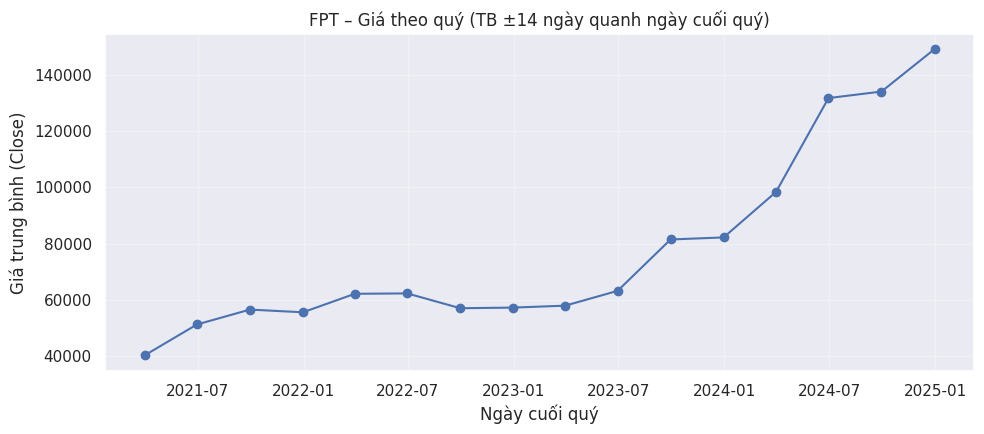

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4.5))
plt.plot(data['quarter_end'], data['close_avg'], marker='o')
plt.title('FPT – Giá theo quý (TB ±14 ngày quanh ngày cuối quý)')
plt.xlabel('Ngày cuối quý'); plt.ylabel('Giá trung bình (Close)')
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()


In [30]:
corr_series = data[num_cols].corr(method='pearson')['close_avg'].sort_values(ascending=False)
corr_series


close_avg         1.000000
pe                0.822593
asset_turnover    0.689207
roe               0.608152
liquidity         0.592545
price_change      0.584883
book_value        0.579691
pct_change        0.315548
eps_growth        0.090649
net_margin       -0.036111
gross_margin     -0.378500
Name: close_avg, dtype: float64

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Chỉ giữ các cột số hợp lệ
num_cols = ['close_avg','gross_margin','net_margin','pe','eps','eps_growth','roe',
            'debt_to_equity','liquidity','asset_turnover','book_value']
num_cols = [c for c in num_cols if c in data.columns]

corr = data[num_cols].corr(method='pearson')

# In ra tương quan của từng chỉ tiêu với giá cổ phiếu
corr_price = corr['close_avg'].sort_values(ascending=False)
print("Tương quan Pearson giữa giá cổ phiếu và các chỉ tiêu tài chính:\n")
print(corr_price)


Tương quan Pearson giữa giá cổ phiếu và các chỉ tiêu tài chính:

close_avg         1.000000
pe                0.822593
asset_turnover    0.689207
roe               0.608152
liquidity         0.592545
book_value        0.579691
eps_growth        0.090649
net_margin       -0.036111
gross_margin     -0.378500
Name: close_avg, dtype: float64


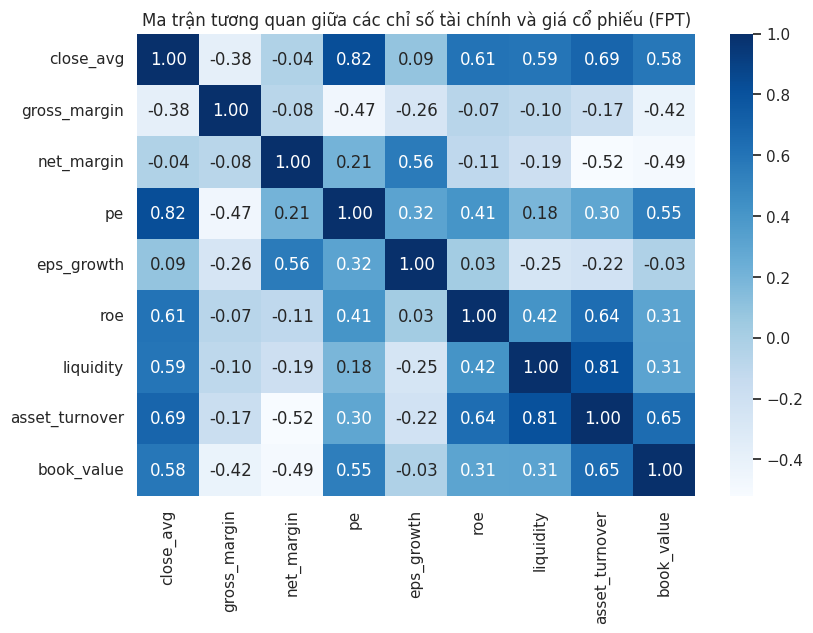

In [32]:
plt.figure(figsize=(9,6))
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f")
plt.title("Ma trận tương quan giữa các chỉ số tài chính và giá cổ phiếu (FPT)")
plt.show()


In [33]:
desc_5num = data.describe(percentiles=[.25,.5,.75])
desc_5num


,quarter_end,close_avg,price_change,pct_change,gross_margin,net_margin,pe,eps_growth,roe,liquidity,asset_turnover,book_value
count,16,16.000000,15.000000,15.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,2023-02-14 00:00:00,77516.321595,7273.536270,0.098017,0.386031,0.149375,20.231936,0.046906,0.273169,1.880789,0.214974,18794.487313
min,2021-03-31 00:00:00,40156.955945,-5279.104334,-0.084803,0.368000,0.124200,15.613727,-0.140900,0.248200,1.663647,0.175968,17487.068514
25%,2022-03-08 12:00:00,56852.407163,456.294476,0.006467,0.378600,0.145775,17.890386,0.036275,0.268225,1.740728,0.187551,18284.695746
50%,2023-02-14 00:00:00,62183.310598,5275.738949,0.091141,0.385350,0.151250,19.316354,0.044200,0.277000,1.869156,0.224419,18661.771314
75%,2024-01-22 18:00:00,86247.003908,13065.018951,0.157938,0.392775,0.155150,21.860240,0.072000,0.280850,1.992736,0.239408,19298.557479
max,2024-12-31 00:00:00,149260.000000,33418.928006,0.339602,0.406300,0.158100,27.016817,0.151400,0.289100,2.142787,0.252270,20300.156504
std,NaN,33356.475751,10019.984178,0.126322,0.011811,0.008755,3.566601,0.064697,0.011383,0.154341,0.026664,845.833500


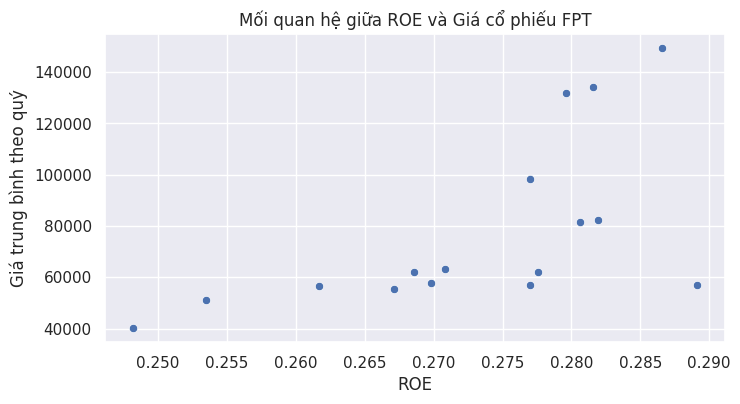

In [34]:
plt.figure(figsize=(8,4))
sns.scatterplot(data=data, x='roe', y='close_avg')
plt.title('Mối quan hệ giữa ROE và Giá cổ phiếu FPT')
plt.xlabel('ROE'); plt.ylabel('Giá trung bình theo quý')
plt.show()
